In [2]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 45.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import tensorflowjs as tfjs
import seaborn as sns
import math
import sys
from math import sqrt

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
camping_df = pd.read_csv('review_camping.csv')
camping_df.head()

,user_id,camping_id,nama_camping,rating,review
0,U0001,C0001,Buper Ipukan,4,"The place has a really forest atmosphere, the ..."
1,U0002,C0001,Buper Ipukan,4,Bnyak byar nya
2,U0003,C0001,Buper Ipukan,5,Very suitable for traveling to relieve fatigue...
3,U0004,C0001,Buper Ipukan,5,A comfortable place to camp with friends or fa...
4,U0005,C0001,Buper Ipukan,5,"The view is great, the air is cool for the min..."


In [5]:
camping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       592 non-null    object
 1   camping_id    592 non-null    object
 2   nama_camping  592 non-null    object
 3   rating        592 non-null    int64 
 4   review        592 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.2+ KB


In [6]:
df = camping_df
df.columns = df.columns.str.replace(' ', '_')

In [7]:
df.head()

,user_id,camping_id,nama_camping,rating,review
0,U0001,C0001,Buper Ipukan,4,"The place has a really forest atmosphere, the ..."
1,U0002,C0001,Buper Ipukan,4,Bnyak byar nya
2,U0003,C0001,Buper Ipukan,5,Very suitable for traveling to relieve fatigue...
3,U0004,C0001,Buper Ipukan,5,A comfortable place to camp with friends or fa...
4,U0005,C0001,Buper Ipukan,5,"The view is great, the air is cool for the min..."


In [8]:
sparse_features = ['user_id', 'camping_id']

In [9]:
dense_features = ['rating']

In [10]:
df[dense_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   rating  592 non-null    int64
dtypes: int64(1)
memory usage: 4.8 KB


### Generate feature columns

In [11]:
def process_sparse_feats(df, feats):
    d = df.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])

    return d

In [12]:
data_sparse = process_sparse_feats(df, sparse_features)

In [13]:
total_data = pd.concat([df[dense_features], data_sparse], axis=1)

In [14]:
df['id_camping_num_only'] = df['camping_id'].map(lambda x: x.lstrip('C'))
df['id_camping_num_only'] = df['id_camping_num_only'].astype(int)

In [15]:
df['id_camping_num_only'] = df['id_camping_num_only'].astype(int)
total_data

,rating,user_id,camping_id
0,4,0,0
1,4,1,0
2,5,2,0
3,5,3,0
4,5,4,0
...,...,...,...
587,4,587,59
588,4,588,59
589,5,589,59
590,5,590,59


In [16]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   rating      592 non-null    int64
 1   user_id     592 non-null    int64
 2   camping_id  592 non-null    int64
dtypes: int64(3)
memory usage: 14.0 KB


In [17]:
# Construct the input of dense features
dense_inputs = []
for f in dense_features:
    _input = Input([1], name=f)
    dense_inputs.append(_input)
# Splicing the inputs together for easy connection to the Dense layer
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)
# Then connect to a fully connected layer whose output is 1 unit, indicating a weighted sum of dense variables
fst_order_dense_layer = Dense(1)(concat_dense_inputs)

In [18]:
# Here the input is constructed separately for each sparse feature,
# The purpose is to facilitate the construction of second-order combined features later
sparse_inputs = []
for f in sparse_features:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

sparse_1d_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    # use l2 regularization to prevent overfitting
    reg = tf.keras.regularizers.l2(0.5)
    _embed = Embedding(voc_size, 1, embeddings_regularizer=reg)(_input)
    # Since the result of Embedding is two-dimensional,
    # So if you need to add the Dense layer after Embedding, you need to connect the Flatten layer first
    _embed = Flatten()(_embed)
    sparse_1d_embed.append(_embed)
# Sum the results wi of each embedding lookup
fst_order_sparse_layer = Add()(sparse_1d_embed)

In [19]:
linear_part = Add()([fst_order_dense_layer, fst_order_sparse_layer])

### Create the Network

In [20]:
# embedding size
k = 270

# Only consider second-order intersection of sparse
sparse_kd_embed = []
for i, _input in enumerate(sparse_inputs):
    f = sparse_features[i]
    voc_size = total_data[f].nunique()
    reg = tf.keras.regularizers.l2(0.7)
    _embed = Embedding(voc_size, k, embeddings_regularizer=reg)(_input)
    sparse_kd_embed.append(_embed)

In [21]:
concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed)

In [22]:
sum_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(concat_sparse_kd_embed)
square_sum_kd_embed = Multiply()([sum_kd_embed, sum_kd_embed])

In [23]:
square_kd_embed = Multiply()([concat_sparse_kd_embed, concat_sparse_kd_embed])
sum_square_kd_embed = Lambda(lambda x: K.sum(x, axis=1))(square_kd_embed)

In [24]:
sub = Subtract()([square_sum_kd_embed, sum_square_kd_embed])
sub = Lambda(lambda x: x*0.5)(sub)
snd_order_sparse_layer = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub)

### Summarize Model

In [25]:
flatten_sparse_embed = Flatten()(concat_sparse_kd_embed)

In [26]:
fc_layer = Dropout(0.5)(Dense(256, activation='relu')(flatten_sparse_embed))
fc_layer = Dropout(0.3)(Dense(256, activation='relu')(fc_layer))
fc_layer = Dropout(0.1)(Dense(256, activation='relu')(fc_layer))

In [27]:
fc_layer_output = Dense(1)(fc_layer)

In [28]:
output_layer = Add()([linear_part, snd_order_sparse_layer, fc_layer_output])
output_layer = Activation("sigmoid")(output_layer)

In [29]:
model = Model(dense_inputs+sparse_inputs, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 camping_id (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 270)               159840    ['user_id[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 270)               16200     ['camping_id[0][0]']          
                                                                                              

In [30]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['binary_accuracy'])

### Train Network

In [31]:
train_data, test_data = train_test_split(total_data, test_size=0.8)

In [32]:
train_dense_x = [train_data[f].values for f in dense_features]
train_sparse_x = [train_data[f].values for f in sparse_features]

In [33]:
train_label = [train_data['rating'].values]

In [34]:
test_dense_x = [test_data[f].values for f in dense_features]
test_sparse_x = [test_data[f].values for f in sparse_features]

In [35]:
test_label = [test_data['rating'].values]

In [36]:
history = model.fit(
    train_dense_x+train_sparse_x,
    train_label,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_data=(test_dense_x+test_sparse_x, test_label))

Epoch 1/20
4/4 [==============================] - 2s 138ms/step - loss: 121.6409 - binary_accuracy: 0.0000e+00 - val_loss: 106.3884 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
4/4 [==============================] - 0s 37ms/step - loss: 98.8356 - binary_accuracy: 0.0000e+00 - val_loss: 85.8144 - val_binary_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 0s 37ms/step - loss: 78.8236 - binary_accuracy: 0.0085 - val_loss: 67.4568 - val_binary_accuracy: 0.0295
Epoch 4/20
4/4 [==============================] - 0s 37ms/step - loss: 60.1244 - binary_accuracy: 0.0593 - val_loss: 49.7072 - val_binary_accuracy: 0.0633
Epoch 5/20
4/4 [==============================] - 0s 28ms/step - loss: 40.0177 - binary_accuracy: 0.0678 - val_loss: 29.4759 - val_binary_accuracy: 0.0633
Epoch 6/20
4/4 [==============================] - 0s 31ms/step - loss: 13.7424 - binary_accuracy: 0.0678 - val_loss: 2.5102 - val_binary_accuracy: 0.0633
Epoch 7/20
4/4 [==============================] - 0s

In [37]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [38]:
pred_ans = model.predict(test_dense_x+test_sparse_x, batch_size=32)

15/15 [==============================] - 0s 3ms/step


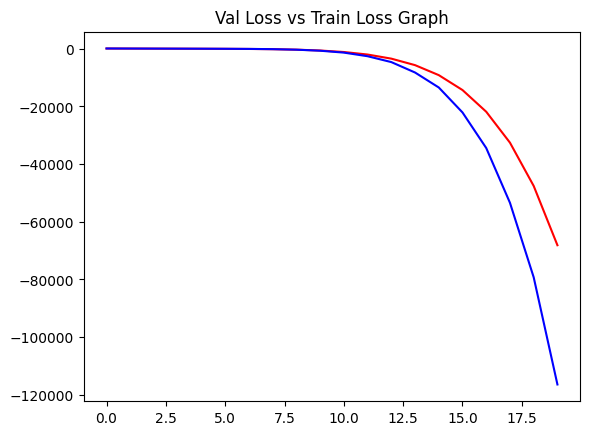

In [39]:
# summarize history for loss
plt.plot(history.history['val_loss'], color='r', label='Val Loss')
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.title('Val Loss vs Train Loss Graph')
plt.show()

In [ ]:
model.save('Camping_Model_RecSys.h5')

In [40]:
tfjs.converters.save_keras_model(model, 'models')